## Required libraries

In [1]:
import math
import random

import matplotlib.pyplot as plt

## Define network and host classes

In [2]:
class AIMDUser:
    def __init__(self, initial_cwnd=1, AI=1, MD=0.5, settings=["linear","linear"]):
        self.cwnd = initial_cwnd
        # own congestion window record
        self.record = [initial_cwnd]
        self.AI = AI
        self.MD = MD
        self.settings = settings
        
        self.alpha = self.AI
        self.beta = self.MD

    def increase(self):
        if (self.settings[0] == "linear"):
            # AI phase: Increase congestion window linearly (by 1 per RTT)
            self.alpha = self.AI
            self.cwnd += self.alpha
            self.recording()
        if (self.settings[0] == "exponent"):
            exponent = 1/3
            self.alpha = self.AI * math.pow(self.cwnd, exponent)
            self.cwnd += self.alpha
            self.recording()
        if (self.settings[0] == "log"):
            # +1 in case cwnd starts with 0 or 1
            self.alpha = self.AI * math.log(self.cwnd + 1)
            self.cwnd += self.alpha
            self.recording()
        if (self.settings[0] == "inverse-exponent"):
            exponent = 1/3
            self.alpha = self.AI / math.pow(self.cwnd, exponent)
            self.cwnd += self.alpha
            self.recording()
        if (self.settings[0] == "inverse-log"):
            # +1 in case cwnd starts with 0 or 1
            self.alpha = self.AI / math.log(self.cwnd + 1)
            self.cwnd += self.alpha
            self.recording()
            

    def decrease(self):
        if (self.settings[1] == "linear"):
            # MD phase: Decrease congestion window by MD on packet loss
            self.beta = self.MD
            self.cwnd *= self.beta 
            self.recording()
        if (self.settings[1] == "log"):
            # MD phase: Decrease congestion window by MD on packet loss
            self.beta = 1 - (1 / math.log(self.cwnd + 10))
            self.cwnd *= self.beta 
            self.recording()
        if (self.settings[1] == "non-linear"):
            self.beta = self.MD*1/(1+math.exp(-self.cwnd))
            self.cwnd *= self.beta
            self.recording()
        
    def recording(self):
        self.record.append(self.cwnd)

        
class Network:
    def __init__(self, num_users=2, initial_cwnd=[1,1], AI=[1,1], MD=[1,1], 
                 settings=[["linear","linear"], ["linear","linear"]], max_cwnd= 100):
        # Create number of users
        self.users = [AIMDUser(initial_cwnd=initial_cwnd[num], AI = AI[num], MD = MD[num], settings = settings[num]) for num in range(num_users)]
        self.max_cwnd = max_cwnd
        
        self.total_cwnd = sum(user.cwnd for user in self.users)
    
    def simulate(self):
        # Random packet loss phase
        if self.detect_packet_loss():
            for user in self.users:
                user.decrease()
        # MD phase
        elif self.total_cwnd > self.max_cwnd:
            for user in self.users:
                user.decrease()
        # AI phase
        else:
            for user in self.users:
                user.increase()
        
        # Update total congestion window
        self.total_cwnd = sum(user.cwnd for user in self.users)

    def detect_packet_loss(self):
        # Simulate packet loss detection (e.g., timeout or duplicate ACKs)
        
        # Return True if packet loss is detected, else False
        
        return False
    
    def modify_max_cwnd(self, new_max_cwnd):
        self.max_cwnd = new_max_cwnd
    
    def add_user(self, user):
        if isinstance(user, AIMDUser):
            self.users.append(user)
            self.total_cwnd = sum(user.cwnd for user in self.users)
        else:
            raise Exception("Class mismatch")
            
        return
    
    def remove_user(self, user_num):
        self.users.remove(user_num)
        
        return
        
        
        


# Simulate 2 users and fairness lines

- 2 users with identical AIMD parameters
- 2 users with different AIMD parameters

## 2 users with identical AIMD parameters

In [3]:
# Create a shared bottleneck link
bottleneck_cwnd = 100

# Create multiple AIMD users
num_users = 2

cwnd_range = 30
precision = 3

# initial_cwnd = [round(random.random() * cwnd_range, precision) for _ in range(num_users)]
initial_cwnd = [1,100]
print("initial cwnd: ", initial_cwnd)

# Manual settings
AI = [1,1]
MD = [0.5,0.5]
settings = [["linear","linear"], ["linear","linear"]]

# Repeated settings
# settings = []
# repeat_settings = ["linear","linear"]
# for _ in range(num_users):
#     settings.append(repeat_settings)
# AI = [1 for _ in range(num_users)]
# MD = [0.5 for _ in range(num_users)]


# Initialize traffic network
traffic_network = Network(num_users=num_users, initial_cwnd=initial_cwnd, AI=AI, MD=MD, settings=settings, max_cwnd= bottleneck_cwnd)

# Number of interactions among users
num_rounds = 250

for _ in range(num_rounds):
    traffic_network.simulate()
    
# Print final congestion window sizes for each user
for i, user in enumerate(traffic_network.users):
    print(f"User {i + 1}: Final cwnd = {user.cwnd}")

initial cwnd:  [1, 100]
User 1: Final cwnd = 39.9521484375
User 2: Final cwnd = 40.048828125


In [4]:
# Calculate Fairness Line
"""
By using Perron-Frobenius right eigenvector, we can find insights on fairness, rate
of convergence and transient response

This is by calculating the limit of each user and observing proportional shares based on this limit, 
alpha/1-beta at congestion event
"""
user_proportion = []

# Take alpha and beta values after multiple iterations
for i, user in enumerate(traffic_network.users):
    alpha = user.alpha
    beta = user.beta
    proportion = alpha/(1-beta)
    user_proportion.append(proportion)

print("Limit Value before Scaling: ", user_proportion)
# For scaling
max_value = max(user_proportion)

# For plotting this vector into a line
for i, vector_value in enumerate(user_proportion):
    scaled_vector_value = vector_value / max_value
    user_proportion[i] = scaled_vector_value * bottleneck_cwnd
    
print("Scaled to graph value: ", user_proportion)

Limit Value before Scaling:  [2.0, 2.0]
Scaled to graph value:  [100.0, 100.0]


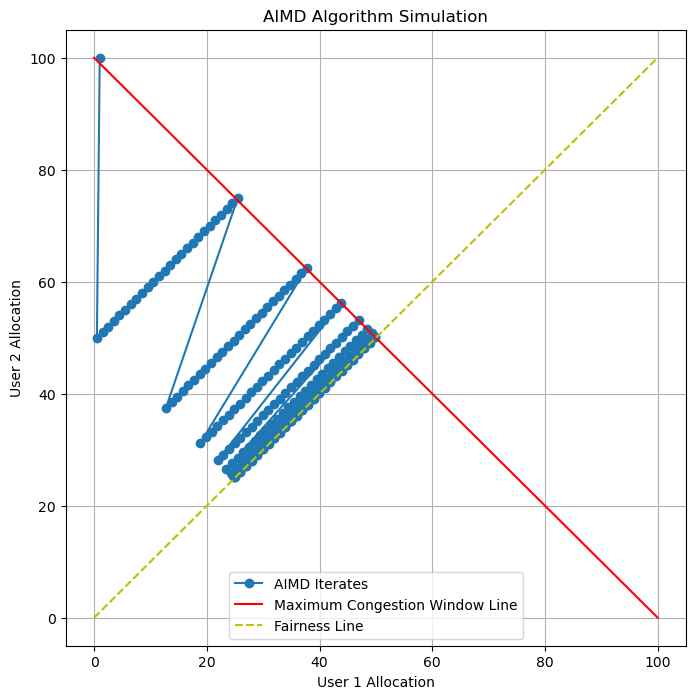

In [5]:
plot = []
rounds = [i for i in range(bottleneck_cwnd + 1)]

# Print congestion record for each user
for i, user in enumerate(traffic_network.users):
    plot.append(user.record)
    alpha = user.alpha
    
x = plot[0]
y = plot[1]


plt.figure(figsize = (8, 8))
plt.plot(x, y, '-o', label = 'AIMD Iterates')
plt.plot([bottleneck_cwnd,0], [0,bottleneck_cwnd], 'r', label = 'Maximum Congestion Window Line')
# plt.plot([bottleneck_cwnd + 2*alpha, 0], [0, bottleneck_cwnd + 2*alpha], 'g', label = 'Full bandwidth utilization line')
plt.plot([0, user_proportion[0]], [0, user_proportion[1]], 'y--', label = 'Fairness Line')
plt.xlabel('User 1 Allocation')
plt.ylabel('User 2 Allocation')
plt.title('AIMD Algorithm Simulation')
plt.grid(True)
plt.legend()
plt.show()

## 2 users with different AIMD parameters

In [6]:
# Create a shared bottleneck link
bottleneck_cwnd = 100

# Create multiple AIMD users
num_users = 2

cwnd_range = 30
precision = 3

# initial_cwnd = [round(random.random() * cwnd_range, precision) for _ in range(num_users)]
initial_cwnd = [50,50]
print("initial cwnd: ", initial_cwnd)

# Manual settings
AI = [4,1]
MD = [0.5,0.5]
settings = [["linear","linear"], ["linear","linear"]]

# Repeated settings
# settings = []
# repeat_settings = ["linear","linear"]
# for _ in range(num_users):
#     settings.append(repeat_settings)
# AI = [1 for _ in range(num_users)]
# MD = [0.5 for _ in range(num_users)]


# Initialize traffic network
traffic_network = Network(num_users=num_users, initial_cwnd=initial_cwnd, AI=AI, MD=MD, settings=settings, max_cwnd= bottleneck_cwnd)

# Number of interactions among users
num_rounds = 250

for _ in range(num_rounds):
    traffic_network.simulate()
    
# Print final congestion window sizes for each user
for i, user in enumerate(traffic_network.users):
    print(f"User {i + 1}: Final cwnd = {user.cwnd}")

initial cwnd:  [50, 50]
User 1: Final cwnd = 63.99999690055847
User 2: Final cwnd = 16.000003695487976


In [7]:
# Calculate Fairness Line
"""
By using Perron-Frobenius right eigenvector, we can find insights on fairness, rate
of convergence and transient response

This is by calculating the limit of each user and observing proportional shares based on this limit, 
alpha/1-beta at congestion event
"""
user_proportion = []

# Take alpha and beta values after multiple iterations
for i, user in enumerate(traffic_network.users):
    alpha = user.alpha
    beta = user.beta
    proportion = alpha/(1-beta)
    user_proportion.append(proportion)

print("Limit Value before Scaling: ", user_proportion)
# For scaling
max_value = max(user_proportion)

# For plotting this vector into a line
for i, vector_value in enumerate(user_proportion):
    scaled_vector_value = vector_value / max_value
    user_proportion[i] = scaled_vector_value * bottleneck_cwnd
    
print("Scaled to graph value: ", user_proportion)

Limit Value before Scaling:  [8.0, 2.0]
Scaled to graph value:  [100.0, 25.0]


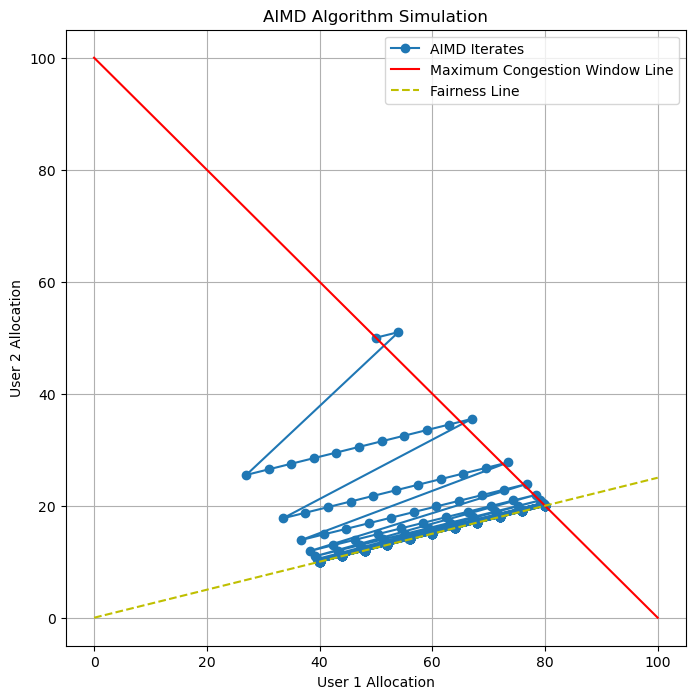

In [8]:
plot = []
rounds = [i for i in range(bottleneck_cwnd + 1)]

# Print congestion record for each user
for i, user in enumerate(traffic_network.users):
    plot.append(user.record)
    alpha = user.alpha
    
x = plot[0]
y = plot[1]


plt.figure(figsize = (8, 8))
plt.plot(x, y, '-o', label = 'AIMD Iterates')
plt.plot([bottleneck_cwnd,0], [0,bottleneck_cwnd], 'r', label = 'Maximum Congestion Window Line')
# plt.plot([bottleneck_cwnd + 2*alpha, 0], [0, bottleneck_cwnd + 2*alpha], 'g', label = 'Full bandwidth utilization line')
plt.plot([0, user_proportion[0]], [0, user_proportion[1]], 'y--', label = 'Fairness Line')
plt.xlabel('User 1 Allocation')
plt.ylabel('User 2 Allocation')
plt.title('AIMD Algorithm Simulation')
plt.grid(True)
plt.legend()
plt.show()

# Simulate more than 2 users

- Same AIMD parameters
- Max Congestion Window changes
- Users enter or exit over RTT

## Same AIMD parameters

In [9]:
# Create a shared bottleneck link
bottleneck_cwnd = 1000

# Create multiple AIMD users
num_users = 10

cwnd_range = 30
precision = 3

# initial_cwnd = [round(random.random() * cwnd_range, precision) for _ in range(num_users)]
initial_cwnd = [10 * user for user in range(1, num_users+1)]
print("initial cwnd: ", initial_cwnd)

# AI = [1,1,1,1]
# MD = [0.5,0.5,0.5,0.5]
# settings = [["linear","non-linear"], ["linear","non-linear"], ["linear","non-linear"], ["linear","non-linear"]]

# Repeated settings
settings = []
repeat_settings = ["linear","linear"]
for _ in range(num_users):
    settings.append(repeat_settings)
AI = [1 for _ in range(num_users)]
MD = [0.5 for _ in range(num_users)]


# Initialize traffic network
traffic_network = Network(num_users=num_users, initial_cwnd=initial_cwnd, AI=AI, MD=MD, settings=settings, max_cwnd= bottleneck_cwnd)

# Number of interactions among users
num_rounds = 650

for _ in range(num_rounds):
    traffic_network.simulate()
    
# Print final congestion window sizes for each user
for i, user in enumerate(traffic_network.users):
    print(f"User {i + 1}: Final cwnd = {user.cwnd}")

initial cwnd:  [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
User 1: Final cwnd = 91.9892578125
User 2: Final cwnd = 91.99169921875
User 3: Final cwnd = 91.994140625
User 4: Final cwnd = 91.99658203125
User 5: Final cwnd = 91.9990234375
User 6: Final cwnd = 92.00146484375
User 7: Final cwnd = 92.00390625
User 8: Final cwnd = 92.00634765625
User 9: Final cwnd = 92.0087890625
User 10: Final cwnd = 92.01123046875


In [10]:
# Calculate Fairness Line
"""
By using Perron-Frobenius right eigenvector, we can find insights on fairness, rate
of convergence and transient response

This is by calculating the limit of each user and observing proportional shares based on this limit, 
alpha/1-beta at congestion event
"""
user_proportion = []

# Take alpha and beta values after multiple iterations
for i, user in enumerate(traffic_network.users):
    alpha = user.alpha
    beta = user.beta
    proportion = alpha/(1-beta)
    user_proportion.append(proportion)

print("Limit Value before Scaling: ", user_proportion)
# For scaling
sum_value = sum(user_proportion)

# For plotting this vector into a line
for i, vector_value in enumerate(user_proportion):
    scaled_vector_value = vector_value / sum_value
    user_proportion[i] = scaled_vector_value * bottleneck_cwnd
    
print("Scaled to graph value: ", user_proportion)

Limit Value before Scaling:  [2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0]
Scaled to graph value:  [100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0]


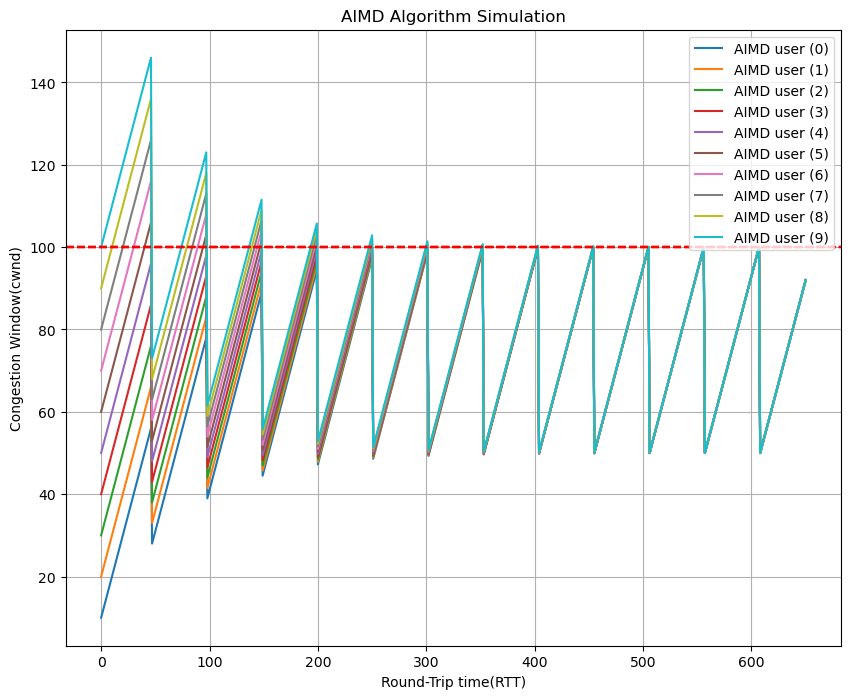

In [11]:
rounds = [round for round in range(num_rounds+1)]

plt.figure(figsize = (10, 8))

for i, user in enumerate(traffic_network.users):
#     plt.plot(rounds, user.record, '-o', label = 'AIMD user ({})'.format(i))
    plt.plot(rounds, user.record, label = 'AIMD user ({})'.format(i))

for user in range(num_users):
    plt.axhline(y = user_proportion[user], color = 'r', linestyle = 'dashed') 

plt.xlabel('Round-Trip time(RTT)')
plt.ylabel('Congestion Window(cwnd)')
plt.title('AIMD Algorithm Simulation')
plt.grid(True)
plt.legend()
plt.show()

## Max Congestion Window changes

In [12]:
# Create scenarios for how to initialize congestion window
# and create scenarios for users to enter or exit

In [13]:
# Create a shared bottleneck link
bottleneck_cwnd = 1000

# Create multiple AIMD users
num_users = 4

cwnd_range = 30
precision = 3

# initial_cwnd = [round(random.random() * cwnd_range, precision) for _ in range(num_users)]
initial_cwnd = [10 * user for user in range(1, num_users+1)]
print("initial cwnd: ", initial_cwnd)

# AI = [1,1,1,1]
# MD = [0.5,0.5,0.5,0.5]
# settings = [["linear","non-linear"], ["linear","non-linear"], ["linear","non-linear"], ["linear","non-linear"]]

# Repeated settings
settings = []
repeat_settings = ["linear","linear"]
for _ in range(num_users):
    settings.append(repeat_settings)
AI = [1 for _ in range(num_users)]
MD = [0.5 for _ in range(num_users)]


# Initialize traffic network
traffic_network = Network(num_users=num_users, initial_cwnd=initial_cwnd, AI=AI, MD=MD, settings=settings, max_cwnd= bottleneck_cwnd)

# Number of interactions among users
num_rounds = 400

for _ in range(num_rounds):
    traffic_network.simulate()

new_bottleneck_cwnd = 500

# Modify bottleneck_cwnd
traffic_network.modify_max_cwnd(new_bottleneck_cwnd)

for _ in range(num_rounds):
    traffic_network.simulate()

    
# Print final congestion window sizes for each user
for i, user in enumerate(traffic_network.users):
    print(f"User {i + 1}: Final cwnd = {user.cwnd}")

initial cwnd:  [10, 20, 30, 40]
User 1: Final cwnd = 101.95703125
User 2: Final cwnd = 101.9765625
User 3: Final cwnd = 101.99609375
User 4: Final cwnd = 102.015625


In [14]:
# Calculate Fairness Line
"""
By using Perron-Frobenius right eigenvector, we can find insights on fairness, rate
of convergence and transient response

This is by calculating the limit of each user and observing proportional shares based on this limit, 
alpha/1-beta at congestion event
"""
user_proportion = []
new_user_proportion = []

# Take alpha and beta values after multiple iterations
for i, user in enumerate(traffic_network.users):
    alpha = user.alpha
    beta = user.beta
    proportion = alpha/(1-beta)
    user_proportion.append(proportion)
    new_user_proportion.append(proportion)

print("Limit Value before Scaling: ", user_proportion)
# For scaling
sum_value = sum(user_proportion)

# For plotting this vector into a line
for i, vector_value in enumerate(user_proportion):
    scaled_vector_value = vector_value / sum_value
    user_proportion[i] = scaled_vector_value * bottleneck_cwnd
    new_user_proportion[i] = scaled_vector_value * new_bottleneck_cwnd
    
print("Scaled to graph value: ", user_proportion)

Limit Value before Scaling:  [2.0, 2.0, 2.0, 2.0]
Scaled to graph value:  [250.0, 250.0, 250.0, 250.0]


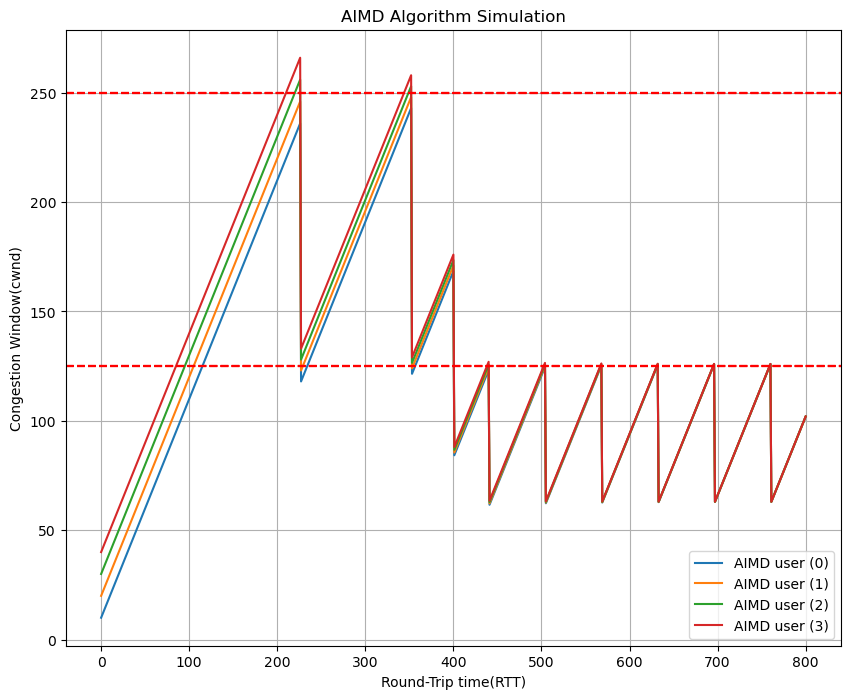

In [15]:
rounds = [round for round in range(num_rounds*2+1)]

plt.figure(figsize = (10, 8))

for i, user in enumerate(traffic_network.users):
#     plt.plot(rounds, user.record, '-o', label = 'AIMD user ({})'.format(i))
    plt.plot(rounds, user.record, label = 'AIMD user ({})'.format(i))

for user in range(num_users):
    plt.axhline(y = user_proportion[user], color = 'r', linestyle = 'dashed')
    plt.axhline(y = new_user_proportion[user], color = 'r', linestyle = 'dashed') 

plt.xlabel('Round-Trip time(RTT)')
plt.ylabel('Congestion Window(cwnd)')
plt.title('AIMD Algorithm Simulation')
plt.grid(True)
plt.legend()
plt.show()

## Users enter or exit over RTT

In [16]:
# Create a shared bottleneck link
bottleneck_cwnd = 1000

# Create multiple AIMD users
num_users = 4

cwnd_range = 30
precision = 3

# initial_cwnd = [round(random.random() * cwnd_range, precision) for _ in range(num_users)]
initial_cwnd = [10 * user for user in range(1, num_users+1)]
print("initial cwnd: ", initial_cwnd)

# AI = [1,1,1,1]
# MD = [0.5,0.5,0.5,0.5]
# settings = [["linear","non-linear"], ["linear","non-linear"], ["linear","non-linear"], ["linear","non-linear"]]

# Repeated settings
settings = []
repeat_settings = ["linear","linear"]
for _ in range(num_users):
    settings.append(repeat_settings)
AI = [1 for _ in range(num_users)]
MD = [0.5 for _ in range(num_users)]


# Initialize traffic network
traffic_network = Network(num_users=num_users, initial_cwnd=initial_cwnd, AI=AI, MD=MD, settings=settings, max_cwnd= bottleneck_cwnd)

# Number of interactions among users
num_rounds = 600

for _ in range(num_rounds):
    traffic_network.simulate() 
    
# Print final congestion window sizes for each user
for i, user in enumerate(traffic_network.users):
    print(f"User {i + 1}: Final cwnd = {user.cwnd}")

initial cwnd:  [10, 20, 30, 40]
User 1: Final cwnd = 244.25
User 2: Final cwnd = 245.5
User 3: Final cwnd = 246.75
User 4: Final cwnd = 248.0


In [17]:
# Calculate Fairness Line
"""
By using Perron-Frobenius right eigenvector, we can find insights on fairness, rate
of convergence and transient response

This is by calculating the limit of each user and observing proportional shares based on this limit, 
alpha/1-beta at congestion event
"""
user_proportion = []

# Take alpha and beta values after multiple iterations
for i, user in enumerate(traffic_network.users):
    alpha = user.alpha
    print(user.beta)
    beta = user.beta
    proportion = alpha/(1-beta)
    user_proportion.append(proportion)

print("Limit Value before Scaling: ", user_proportion)
# For scaling
sum_value = sum(user_proportion)

# For plotting this vector into a line
for i, vector_value in enumerate(user_proportion):
    scaled_vector_value = vector_value / sum_value
    user_proportion[i] = scaled_vector_value * bottleneck_cwnd
    
print("Scaled to graph value: ", user_proportion)

0.5
0.5
0.5
0.5
Limit Value before Scaling:  [2.0, 2.0, 2.0, 2.0]
Scaled to graph value:  [250.0, 250.0, 250.0, 250.0]


In [18]:
# Init new_user
new_user1 = AIMDUser(initial_cwnd=50, AI=1, MD=0.5, settings=["linear","linear"])
new_user2 = AIMDUser(initial_cwnd=100, AI=1, MD=0.5, settings=["linear","linear"])

# Add 2 new users
traffic_network.add_user(new_user1)
traffic_network.add_user(new_user2)

for i in range(num_rounds):
    traffic_network.simulate()
    
# Print final congestion window sizes for each user
for i, user in enumerate(traffic_network.users):
    print(f"User {i + 1}: Final cwnd = {user.cwnd}")
    
# Calculate new fairness line
new_user_proportion = []

# Take alpha and beta values after multiple iterations
for i, user in enumerate(traffic_network.users):
    alpha = user.alpha
    print(user.beta)
    beta = user.beta
    proportion = alpha/(1-beta)
    new_user_proportion.append(proportion)

print("Limit Value before Scaling: ", new_user_proportion)
# For scaling
sum_value = sum(new_user_proportion)

# For plotting this vector into a line
for i, vector_value in enumerate(new_user_proportion):
    scaled_vector_value = vector_value / sum_value
    new_user_proportion[i] = scaled_vector_value * bottleneck_cwnd
    
print("Scaled to graph value: ", new_user_proportion)

User 1: Final cwnd = 101.8837890625
User 2: Final cwnd = 101.888671875
User 3: Final cwnd = 101.8935546875
User 4: Final cwnd = 101.8984375
User 5: Final cwnd = 101.125
User 6: Final cwnd = 101.3203125
0.5
0.5
0.5
0.5
0.5
0.5
Limit Value before Scaling:  [2.0, 2.0, 2.0, 2.0, 2.0, 2.0]
Scaled to graph value:  [166.66666666666666, 166.66666666666666, 166.66666666666666, 166.66666666666666, 166.66666666666666, 166.66666666666666]


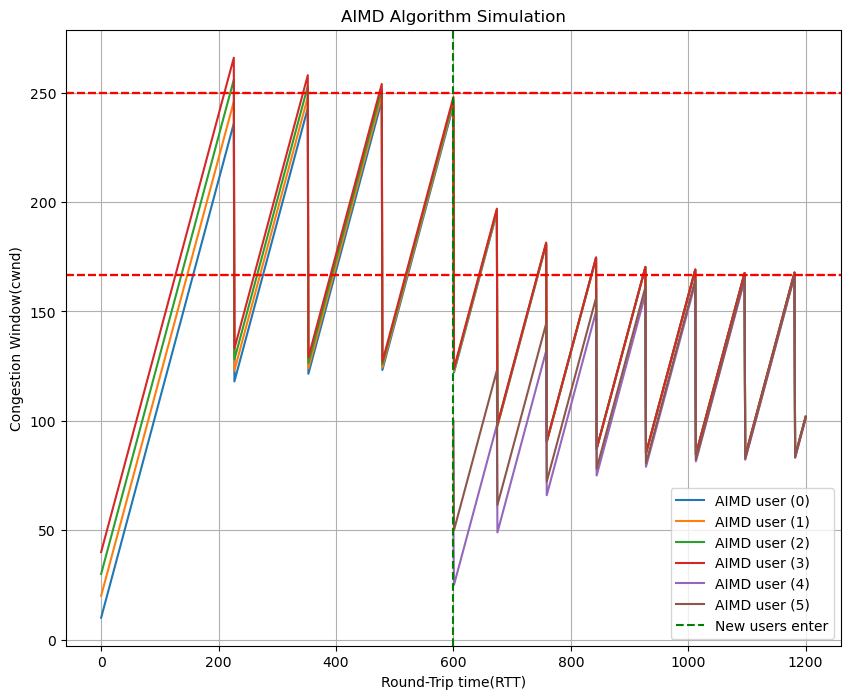

In [19]:
rounds = [round for round in range(num_rounds*2+1)]

plt.figure(figsize = (10, 8))

for i, user in enumerate(traffic_network.users[0:num_users]):
#     plt.plot(rounds, user.record, '-o', label = 'AIMD user ({})'.format(i))
    plt.plot(rounds, user.record, label = 'AIMD user ({})'.format(i))
    

for i, user in enumerate(traffic_network.users[num_users:]):
    plt.plot(range(num_rounds, num_rounds*2+1), user.record, label = 'AIMD user ({})'.format(num_users + i))   

for user in range(num_users):
    plt.axhline(y = user_proportion[user], color = 'r', linestyle = 'dashed')
    plt.axhline(y = new_user_proportion[user], color = 'r', linestyle = 'dashed')
    
plt.axvline(x = num_rounds, color = 'g', linestyle = 'dashed', label= 'New users enter')

plt.xlabel('Round-Trip time(RTT)')
plt.ylabel('Congestion Window(cwnd)')
plt.title('AIMD Algorithm Simulation')
plt.grid(True)
plt.legend()
plt.show()